<a href="https://colab.research.google.com/github/duartegonzaloariel/UDELAR_FireBall/blob/main/UDELAR_FB_CNN_Res152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Librerias**
---



### Instalar

In [1]:
!pip install tensorflow==2.9.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 51.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorboard-data-serv

### Importar

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error, accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from tensorflow.keras.applications import ResNet152V2 as Architecture

import keras
import keras.metrics as metrics
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, CallbackList, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import models, layers, optimizers, Model
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.applications.vgg16 import VGG16

from keras import regularizers

# ResNet152
#from keras.applications.resnet import ResNet152 as Architecture

from PIL import Image
#from google_drive_downloader import GoogleDriveDownloader as gdd
import shutil
import itertools

import os

# **Funciones**

---



In [ ]:
#__________________________________________________________________________
#            Learning Rate Callback
#__________________________________________________________________________

class LearningRateScheduler(Callback):
    def __init__(self, initial_lr=0.0001, factor=0.5, patience=5, min_lr=0.000001):
        super(LearningRateScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.lr = initial_lr
        self.num_epochs_no_improvement = 0

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        if self.num_epochs_no_improvement >= self.patience:
            self.lr = max(self.lr * self.factor, self.min_lr)
            self.num_epochs_no_improvement = 0
            print(f'Reducing learning rate to {self.lr}')
        else:
            self.num_epochs_no_improvement += 1

        logs['lr'] = self.lr




In [ ]:
#__________________________________________________________________________
#            Gestor de train_ds y val_ds
#__________________________________________________________________________
def preprocess_and_visualize_datasets(rutaCarpetasCategorias, image_size, batch_size, SEED, clases):
    # Llamar a la función para crear los datasets
    train_ds, val_ds = crear_datasets(rutaCarpetasCategorias, image_size, batch_size, SEED)

    # Llamada a la función para visualizar imágenes del conjunto de entrenamiento
    visualize_images(train_ds)
    # One Hot-Encode
    train_ds = train_ds.map(lambda x, y: one_hot_encode(x, y, clases))
    val_ds = val_ds.map(lambda x, y: one_hot_encode(x, y, clases))

    return (train_ds,val_ds)

#__________________________________________________________________________
#            Formato one-hot encoding (para 'categorical_crossentropy')
#__________________________________________________________________________
# Función para convertir etiquetas a formato one-hot
def one_hot_encode(image, label, n_classes):
    label = tf.one_hot(label, depth=n_classes)
    return image, label

#__________________________________________________________________________
#            Ver muestra de conjunto de entrenamiento
#__________________________________________________________________________

# Visualización de algunas imágenes
def visualize_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for image, label in zip(images, labels):
            plt.subplot(3, 3, label.numpy() + 1)
            plt.imshow(image.numpy().astype("uint8"))
            plt.title(int(label))
            plt.axis("off")

    plt.show()

#__________________________________________________________________________
#            Conjuntos de entrenamiento y validación
#__________________________________________________________________________
def crear_datasets(ruta, image_size, batch_size, seed=1337, validation_split=0.2):

    # Se crea el conjunto de entrenamiento
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        ruta,
        validation_split=validation_split,
        subset="training",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size,
    )

    # Se crea el conjunto de validación
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        ruta,
        validation_split=validation_split,
        subset="validation",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size,
    )

    return train_ds, val_ds

La función "unfreeze_model" que toma un modelo como entrada y "descongela" las últimas 20 capas del modelo para que puedan ser entrenadas. Esta función es útil cuando deseas ajustar un modelo preentrenado en una tarea específica y quieres descongelar solo un número específico de capas finales para permitir que se ajusten durante el entrenamiento.

In [ ]:
def unfreeze_model(model):
  for layer in model.layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable=True
  return model

La función "modeloCNNimagen" construye un modelo de red neuronal convolucional (CNN) para la clasificación de imágenes. Con opciones para el aumento de datos y el uso de pre-entrenamiento.

In [ ]:
#__________________________________________________________________________
#            Modelo de CNN
#__________________________________________________________________________
def modeloCNNimagen(input_shape,
                    n_classes=2,
                    augmentation=False,
                    model_type='ResNet152V2',
                    trained=False,
                    regularization = None
                    ):
    inputs = keras.Input(shape=input_shape)
    #__________________________________________________________________________
    #                Incorporación Image augmentation block                   #
    #__________________________________________________________________________
    if augmentation:
      data_augmentation = keras.Sequential(
      [
          layers.RandomFlip(mode="horizontal_and_vertical", seed=SEED),
                                #"horizontal_and_vertical"
                                #"horizontal"
                                #"vertical"
          layers.RandomRotation(0.1, seed=SEED),
          layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=SEED),
          layers.RandomZoom(0.2, fill_mode='constant', seed=SEED),
                                          #'nearest' : Rellena los píxeles fuera de los límites de la imagen con el valor del píxel más cercano
                                          #'constant': Rellena los píxeles fuera de los límites de la imagen con un valor constante especificado por el parámetro cval.
                                          #'reflect': Refleja los píxeles más allá de los límites de la imagen.
                                          #'wrap': Envuelve los píxeles más allá de los límites de la imagen alrededor de los bordes.
          layers.RandomContrast(0.01, seed=SEED)
      ],
      name = "data_augmentation")
      x = data_augmentation(inputs)
    else:
      x=inputs

    #__________________________________________________________________________
    #                Weights Regularization
    #__________________________________________________________________________
    if regularization['enabled']:
        if regularization['type'] == 'L1': regularizer = regularizers.L1(regularization['REGULARIZATION_L1'])
        if regularization['type'] == 'L2': regularizer = regularizers.L1(regularization['REGULARIZATION_L2'])
        if regularization['type'] == 'L1L2':
            regularizer = regularizers.L1L2(l1 = regularization['REGULARIZATION_L1'], l2 = regularization['REGULARIZATION_L2'])
    else:
      regularizer = None


    #__________________________________________________________________________
    #           Incorporación del modelo preentrenado ResNet                  #
    #__________________________________________________________________________
    if model_type == 'ResNet18':
        base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet' if pretraining else None, input_shape=input_shape)
    elif model_type == 'ResNet34':
        base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet' if pretraining else None, input_shape=input_shape)
    elif model_type == 'ResNet50':
        base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet' if pretraining else None, input_shape=input_shape)
    elif model_type == 'ResNet101':
        base_model = tf.keras.applications.ResNet101(include_top=False, weights='imagenet' if pretraining else None, input_shape=input_shape)
    elif model_type == 'ResNet152':
        base_model = tf.keras.applications.ResNet152(include_top=False, weights='imagenet' if pretraining else None, input_shape=input_shape)
    elif model_type == 'ResNet200':
        base_model = tf.keras.applications.ResNet200(include_top=False, weights='imagenet' if pretraining else None, input_shape=input_shape)
    elif model_type == 'ResNet50V2':
        base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet' if pretraining else None, input_shape=input_shape)
    elif model_type == 'ResNet101V2':
        base_model = tf.keras.applications.ResNet101V2(include_top=False, weights='imagenet' if pretraining else None, input_shape=input_shape)
    elif model_type == 'ResNet152V2':
        base_model = tf.keras.applications.ResNet152V2(include_top=False, weights='imagenet' if pretraining else None, input_shape=input_shape)
    elif model_type == 'ResNeXt50':
        base_model = tf.keras.applications.ResNeXt50(include_top=False, weights='imagenet' if pretraining else None, input_shape=input_shape)
    elif model_type == 'ResNeXt101':
        base_model = tf.keras.applications.ResNeXt101(include_top=False, weights='imagenet' if pretraining else None, input_shape=input_shape)
    else:
        raise ValueError(f"Modelo {model_type} no reconocido.")

    base_model.trainable = trained

    x = base_model(x, training=pretraining)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2, name='first_dropout')(x)


    #__________________________________________________________________________
    #                      Capas de clasificación final                       #
    #__________________________________________________________________________
    if n_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = n_classes

    x = layers.Dense(256, activation=activation, kernel_regularizer=regularizer, name='first_dense')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2, name='top_dropout')(x)

    outputs = layers.Dense(units, activation=activation,  kernel_regularizer=regularizer, name='pred')(x)

    # Definición del modelo completo
    return keras.Model(inputs, outputs, name=Architecture.__name__)

# **Configuracion MaquinaIA**
---



## Importar datos

Se debe importar los resultados de un EDA previamente estudiado de la base de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importar imagenes

Las imagenes pertenecen a una base de datos en Drive, por lo cual extraemos un batch. Esta variable determina el tamaño del lote, es decir, cuántas imágenes se procesan a la vez durante el entrenamiento del modelo.

 tf.keras.preprocessing.image_dataset_from_directory asigna automáticamente una etiqueta única a cada subdirectorio dentro del directorio principal proporcionado. Entonces se asignará automáticamente la etiqueta 0 al subdirectorio "carpetaA" y la etiqueta 1 al subdirectorio "carpetaB". Por lo tanto, todas las imágenes de carpetaA tendrán la etiqueta 0, y todas las imágenes de carpetaB tendrán la etiqueta 1. La asignación de etiquetas se basa en el orden en que se encuentran las clases al explorar el directorio de datos.

Found 5409 files belonging to 6 classes.
Using 4328 files for training.
Found 5409 files belonging to 6 classes.
Using 1081 files for validation.


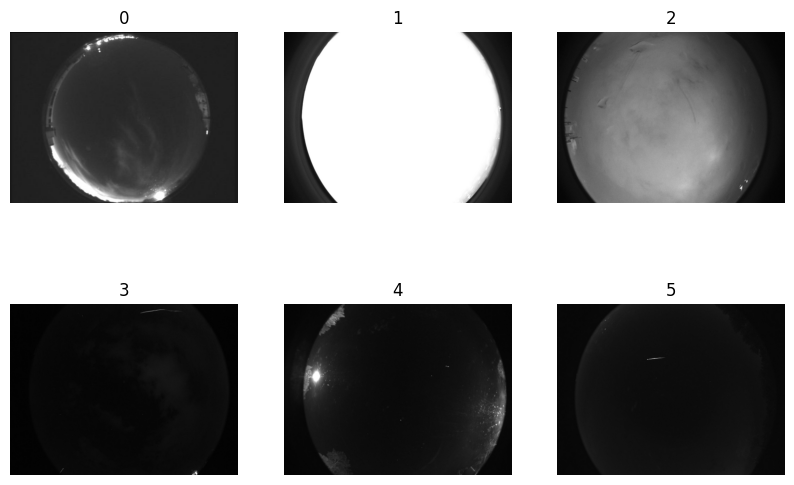

In [ ]:
#__________________________________________________________________________
#               Carga de datos de imágenes
#__________________________________________________________________________
entrenamiento = 'entrenamiento_Watec-ASI'
# Define la ruta de las carpetas de categorías de imágenes
USER = 'GONZALO'
if USER == 'JUAN':
  path_shared = '/content/drive/MyDrive/InvestigacionesPropias/Fireball/entrenamientos'
  path = os.symlink(path_shared, '/content/drive/MyDrive/entrenamientos')
if USER == 'GONZALO':
  path = f'/content/drive/MyDrive/InvestigacionesPropias/Fireball/Resultados/{entrenamiento}'

rutaCarpetasCategorias = f'{path}/{entrenamiento}'

# Definir número de clases
clases = 6

# Configuración de imágenes
SEED = 1337
image_size = (480,640)#480,640
batch_size = 32

# Llamar a la función para realizar todas las operaciones
train_ds,val_ds = preprocess_and_visualize_datasets(rutaCarpetasCategorias, image_size, batch_size, SEED, clases)

## Definir modelo

Funcion perdida:

En "binary_crossentropy" espera etiquetas binarias (0 o 1), mientras que "categorical_crossentropy" espera etiquetas codificadas en caliente (one-hot encoded) para problemas multiclase

In [ ]:
#__________________________________________________________________________
#               Configuracion de Modelo
#__________________________________________________________________________
# Número de clases
n_classes = clases #(definidas con train y test)

# Para imágenes solamente
buffer_size = 32  # controla cuántos elementos de datos se prebuscarán en segundo plano
pretraining = True

model_type = 'ResNet152V2'
              #'ResNet18'
              #'ResNet34'
              #'ResNet50'
              #'ResNet101'
              #'ResNet152'
              #'ResNet200'
              #'ResNet50V2'
              #'ResNet101V2'
              #'ResNet152V2'
              #'ResNeXt50'
              #'ResNeXt101'


trained_model_type = False

augmentation = False


regularization = {
   'enabled'          : True
  ,'type'             : 'L2'
  ,'REGULARIZATION_L1': 1e-4
  ,'REGULARIZATION_L2': 1e-5
  ,'CLIPNORM'         : 3.0
}

# Compilación del modelo
funcionPerdida = 'categorical_crossentropy'
                 #'categorical_crossentropy'
                 #'binary_crossentropy'

optimizador = Adam(learning_rate=1e-5, clipnorm= regularization['CLIPNORM'])
metrica = 'accuracy'

# Entrenamiento del modelo
epochs = 150
verbose = 2
# Definir la ruta donde buscar el modelo
model_path = f'/content/drive/MyDrive/InvestigacionesPropias/Fireball/Resultados/{entrenamiento}/modelo_WatecASI.h5'

# Definir la ruta donde se guardará el modelo
filepath = f'/content/drive/MyDrive/InvestigacionesPropias/Fireball/Resultados/{entrenamiento}/modelo_WatecASI.h5'


# Callbacks individuales
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=2, restore_best_weights=True, patience=5)
checkpoint_callback = ModelCheckpoint(filepath=filepath, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)
lr_scheduler_callback = LearningRateScheduler(initial_lr=0.00025, factor=0.5, patience=5, min_lr=0.000001)#initial_lr=0.0005
callbacks = [early_stopping_callback, checkpoint_callback, lr_scheduler_callback]

# Define la ruta del archivo CSV para guardar el log del entrenamiento
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger(f'/content/drive/MyDrive/InvestigacionesPropias/Fireball/Resultados/{entrenamiento}/WatecASI.csv', append=True)

# Añadir el csv_logger a los callbacks
callbacks.append(csv_logger)


fine_tuning = True

In [ ]:
# Obtener la descripción textual de la arquitectura del modelo
#Llamar al modelo
model = modeloCNNimagen(input_shape=(image_size + (3,)),
                        n_classes=n_classes,
                        augmentation=augmentation,
                        model_type=model_type,
                        trained=trained_model_type,
                        regularization = regularization)

# Fine Tuning
if fine_tuning:
    model = unfreeze_model(model)
keras.utils.plot_model(model, show_shapes=True)
# Obtener la descripción textual de la arquitectura del modelo
model.summary()


234545216/234545216 [==============================] - 11s 0us/step
Model: "ResNet152V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 640, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 15, 20, 2048)      58331648  
                                                                 
 avg_pool (GlobalAveragePool  (None, 2048)             0         
 ing2D)                                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 first_dropout (Dropout)     (None, 2048)              0         
                                                     

Para compilar el modelo, se llama .compile().
Aquí se especifica que función de pérdida usamos, que optimizador y que métricas queremos guardar de cada epoch

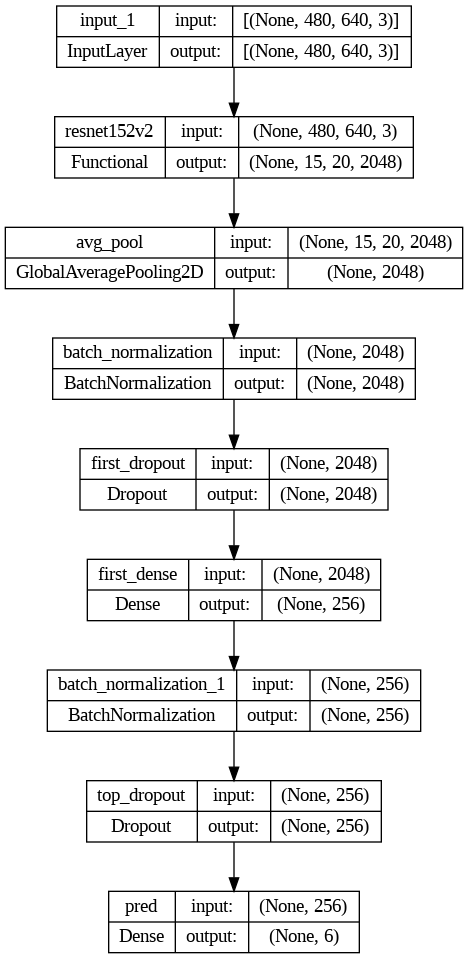

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
modelo_entrenado = True
if modelo_entrenado:
  # Cargar el modelo previamente entrenado sin compilar
  model = tf.keras.models.load_model(model_path, compile=False)
# Compila Modelo
model.compile(loss=funcionPerdida, optimizer=optimizador, metrics=[metrica])


# **Entrenamiento**
---



**loss**

La pérdida (loss) es una métrica que indica qué tan bien el modelo está realizando durante el entrenamiento. 0.35 indica que la pérdida en el conjunto de entrenamiento en este punto específico del entrenamiento es de aproximadamente 0.35.

**accuracy**

La precisión (accuracy) es otra métrica importante que indica la precisión del modelo en el conjunto de entrenamiento. Un valor de 0.80 indica que el modelo tiene una precisión del 80% en el conjunto de entrenamiento en este punto específico del entrenamiento.


**val_loss**

 Esto representa la pérdida en el conjunto de validación (validation loss), que es una métrica similar a la pérdida, pero se calcula utilizando datos de validación en lugar de datos de entrenamiento. Un valor de 0.30 indica que la pérdida en el conjunto de validación en este punto específico del entrenamiento es de aproximadamente 0.30.


**val_accuracy**

Esto representa la precisión en el conjunto de validación (validation accuracy), que es similar a la precisión pero calculada utilizando datos de validación en lugar de datos de entrenamiento. Un valor de 0.90 indica que la precisión del modelo en el conjunto de validación en este punto específico del entrenamiento es del 90%.


**Epoch**

Una época se refiere a una iteración a través de todos los datos de entrenamiento una vez durante el proceso de entrenamiento. Una vez que se completa una época, el modelo ajusta sus pesos para mejorar su rendimiento en los datos de entrenamiento y validación.

In [ ]:
#__________________________________________________________________________
#               Entrenamiento
#__________________________________________________________________________
# Definimos el número de muestras por clase
num_muestras = {
    '0': 1489,
    '1': 148,
    '2': 240,
    '3': 755,
    '4': 1588,
    '5': 1189
}

"""
Watec
    '0': 1058,
    '1': 69,
    '2': 181,
    '3': 366,
    '4': 605,
    '5': 293
total:2572

ASI
    '0': 432,
    '1': 80,
    '2': 61,
    '3': 389,
    '4': 984,
    '5': 896
total:2842

Watec-ASI
    '0': 1489,
    '1': 148,
    '2': 240,
    '3': 755,
    '4': 1588,
    '5': 1189
total:5409
"""

# Número total de muestras
total_muestras = sum(num_muestras.values())

# Número de clases
num_clases = len(num_muestras)

# Calcular pesos de las clases
pesos_clases = {i: total_muestras / (num_clases * num_muestras[str(i)]) for i in range(num_clases)}

print(pesos_clases)


# Entrenar el modelo utilizando los pesos de las clases
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,

    class_weight=pesos_clases,
    callbacks=callbacks
)

{0: 0.6054398925453325, 1: 6.091216216216216, 2: 3.75625, 3: 1.1940397350993377, 4: 0.5676952141057935, 5: 0.7582001682085786}
Epoch 1/150
136/136 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.9503  
Epoch 1: val_loss improved from inf to 0.78093, saving model to /content/drive/MyDrive/InvestigacionesPropias/Fireball/Resultados/entrenamiento_Watec-ASI/modelo_WatecASI.h5
136/136 [==============================] - 11902s 87s/step - loss: 0.4446 - accuracy: 0.9503 - val_loss: 0.7809 - val_accuracy: 0.8279 - lr: 2.5000e-04
Epoch 2/150
136/136 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.9649  
Epoch 2: val_loss improved from 0.78093 to 0.75231, saving model to /content/drive/MyDrive/InvestigacionesPropias/Fireball/Resultados/entrenamiento_Watec-ASI/modelo_WatecASI.h5
136/136 [==============================] - 11672s 86s/step - loss: 0.4090 - accuracy: 0.9649 - val_loss: 0.7523 - val_accuracy: 0.8298 - lr: 2.5000e-04
Epoch 3/150
136/136 [